In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 讓 Python 找得到 src 資料夾
# 假設 notebook 在專案根目錄 (跟 src 同層)
sys.path.append(str(Path.cwd()))

# 設定繪圖風格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 取得目前 notebook 的路徑 (例如 D:\NCKU\paper4\script)
current_dir = Path.cwd()

# 取得上一層目錄 (專案根目錄，例如 D:\NCKU\paper4)
project_root = current_dir.parent

# 把根目錄加入 Python 的搜尋路徑
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"已加入專案路徑: {project_root}")

from src.utils.data_loader import prepare_data
from src.engine.trainer import train_v11
from src.engine.evaluator import evaluate_model
from src.models.network import EnhancedDLinear

# 硬體設定
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

已加入專案路徑: D:\NCKU\paper4
Running on: cuda


In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# 全域設定
DATA_PATH = Path("../dataset/USD_TWD.csv")
HORIZON = 3
LOOKBACK = 30
EPOCHS = 100  # 實驗可以跑少一點 (例如 50-100) 比較快
LR = 0.001

In [4]:
if not DATA_PATH.exists():
    raise FileNotFoundError("找不到資料集！")

df = pd.read_csv(DATA_PATH)

# 載入資料
train_loader, test_loader, scalers, _, _, _, _ = prepare_data(
    df, lookback=LOOKBACK, horizon=HORIZON
)

target_scaler = scalers['target']
print(f"Data ready. Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Data ready. Train batches: 168, Test batches: 42


In [5]:
ablation_experiments = [
    {
        "name": "Full Model (Baseline)",
        "params": {}  # 空字典 = 全部使用預設值 (全開)
    },
    {
        "name": "w/o CNN",
        "params": {"use_cnn": False}  # 關閉 CNN
    },
    {
        "name": "w/o Decomposition",
        "params": {"use_decomp": False}  # 關閉序列分解
    },
    # 如果你有做 Gate 機制也可以測
    # {
    #     "name": "w/o Gating",
    #     "params": {"use_gate": False}
    # }
]

In [6]:
results = []

print(f"開始執行 {len(ablation_experiments)} 組消融實驗...\n")

for i, exp in enumerate(ablation_experiments):
    exp_name = exp["name"]
    exp_params = exp["params"]

    print(f"[{i + 1}/{len(ablation_experiments)}] Running: {exp_name}")
    print(f"   Params: {exp_params}")

    # 1. 重置種子 (確保初始化權重一致)
    set_seed(42)

    # 2. 訓練模型
    # 注意：這裡使用了我們剛改好的 model_hyperparams 機制
    model = train_v11(
        train_loader=train_loader,
        test_loader=test_loader,
        device=DEVICE,
        horizon=HORIZON,
        num_epochs=EPOCHS,
        lr=LR,
        model_hyperparams=exp_params  # <--- 關鍵傳遞
    )

    # 3. 評估模型
    metrics = evaluate_model(
        model=model,
        test_loader=test_loader,
        scaler=target_scaler,
        device=DEVICE,
        horizon=HORIZON
    )

    # 4. 儲存結果
    # 假設 metrics 回傳 {'MSE': 0.1, 'MAE': 0.2, ...}
    record = {"Experiment": exp_name}
    record.update(metrics)
    results.append(record)

    print(f"   Result: MSE={metrics.get('MSE', 'N/A'):.4f}\n")

print("所有實驗結束！")

開始執行 3 組消融實驗...

[1/3] Running: Full Model (Baseline)
   Params: {}

[Training] Enhanced DLinear...
  Epoch 20 | Loss: 0.3197 | Trend W: -0.020 | Seas W: 0.079

 FINAL MODEL EVALUATION (Horizon=3): Hybrid Architecture Analysis
 (Gating Weights -> Trend: -0.0202 | Seasonal: 0.0786)
Metric               | Linear Base     | Enhanced        | Improvement    
-----------------------------------------------------------------------------------------------
R2 Score             | 0.7139          | 0.8036          | +0.0897 ✅
RMSE                 | 1.9045          | 1.5781          | -0.3264 ✅
Avg Accuracy         | 0.5774          | 0.7381          | +0.1607 ✅
   Result: MSE=2.4905

[2/3] Running: w/o CNN
   Params: {'use_cnn': False}

[Training] Enhanced DLinear...
  Epoch 20 | Loss: 0.4297 | Trend W: 0.000 | Seas W: 0.000

 MODEL EVALUATION (Horizon=3): Baseline (No-CNN)
Metric                    | Score          
-------------------------------------------------------------------------------


=== Ablation Study Results ===


,Experiment,MSE,RMSE,MAE,R2,Acc,High_Vol_Acc
0,Full Model (Baseline),2.490505,1.578133,0.0,0.803575,0.738150,0.887199
1,w/o CNN,3.401102,1.844208,0.0,0.731757,0.637262,0.776933
2,w/o Decomposition,2.492271,1.578693,0.0,0.803436,0.730798,0.889734


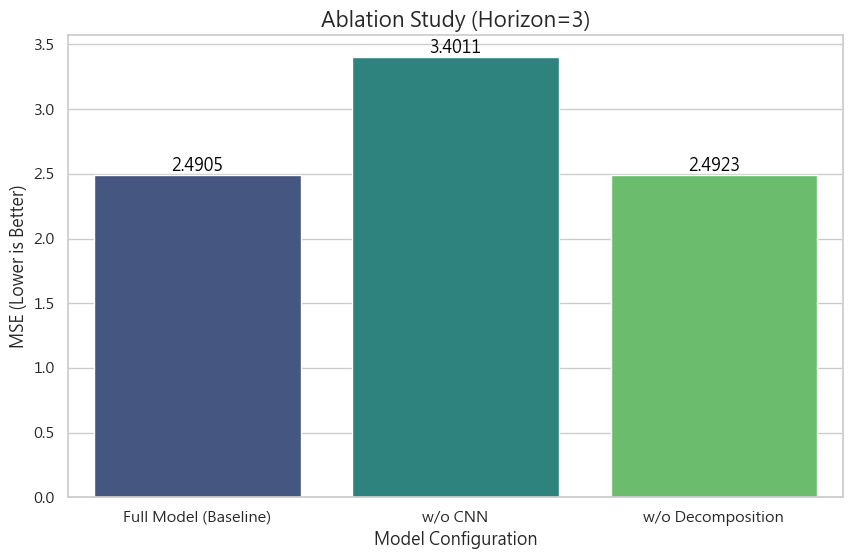

In [7]:
# 轉成 DataFrame
df_res = pd.DataFrame(results)

# 顯示表格
print("\n=== Ablation Study Results ===")
display(df_res)  # Jupyter 裡用 display 比較漂亮

# 畫圖比較 (Bar Plot)
plt.figure(figsize=(10, 6))
# 這裡假設你的指標是 'MSE'，如果是其他請自行修改 y
sns.barplot(data=df_res, x='Experiment', y='MSE', hue='Experiment', palette='viridis', legend=False)

plt.title(f"Ablation Study (Horizon={HORIZON})", fontsize=15)
plt.ylabel("MSE (Lower is Better)")
plt.xlabel("Model Configuration")

# 在柱狀圖上標示數值
for index, row in df_res.iterrows():
    plt.text(index, row['MSE'], f"{row['MSE']:.4f}", color='black', ha="center", va="bottom")

plt.show()

# 存檔備份
df_res.to_csv("ablation_results.csv", index=False)